In [1]:
import pertpy as pt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import numpy as np
import seaborn as sns
from tqdm import tqdm
import anndata
import scanpy as sc

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:
adata = pt.dt.norman_2019()

In [3]:
G1_CYCLE = [
    "CDKN1A",
    {"CDKN1B", "CDKN1A"},
    "CDKN1B",
    {"CDKN1C", "CDKN1A"},
    {"CDKN1C", "CDKN1B"},
    "CDKN1C",
]

ERYTHROID = [
    {"CBL", "CNN1"},
    {"CBL", "PTPN12"},
    {"CBL", "PTPN9"},
    {"CBL", "UBASH3B"},
    {"SAMD1", "PTPN12"},
    {"SAMD1", "UBASH3B"},
    {"UBASH3B", "CNN1"},
    {"UBASH3B", "PTPN12"},
    {"UBASH3B", "PTPN9"},
    {"UBASH3B", "UBASH3A"},
    {"UBASH3B", "ZBTB25"},
    {"BPGM", "SAMD1"},
    "PTPN1",
    {"PTPN12", "PTPN9"},
    {"PTPN12", "UBASH3A"},
    {"PTPN12", "ZBTB25"},
    {"UBASH3A", "CNN1"},
]

PIONEER_FACTORS = [
    {"FOXA1", "FOXF1"},
    {"FOXA1", "FOXL2"},
    {"FOXA1", "HOXB9"},
    {"FOXA3", "FOXA1"},
    {"FOXA3", "FOXF1"},
    {"FOXA3", "FOXL2"},
    {"FOXA3", "HOXB9"},
    "FOXA3",
    {"FOXF1", "FOXL2"},
    {"FOXF1", "HOXB9"},
    {"FOXL2", "MEIS1"},
    "HOXA13",
    "HOXC13",
    {"POU3F2", "FOXL2"},
    "TP73",
    "MIDN",
    {"LYL1", "IER5L"},
    "HOXC13",
    {"DUSP9", "SNAI1"},
    {"ZBTB10", "SNAI1"},
]

GRANULOCYTE_APOPTOSIS = [
    "SPI1",
    "CEBPA",
    {"CEBPB", "CEBPA"},
    "CEBPB",
    {"CEBPE", "CEBPA"},
    {"CEBPE", "CEBPB"},
    {"CEBPE", "RUNX1T1"},
    {"CEBPE", "SPI1"},
    "CEBPE",
    {"ETS2", "CEBPE"},
    {"KLF1", "CEBPA"},
    {"FOSB", "CEBPB"},
    {"FOSB", "CEBPE"},
    {"ZC3HAV1", "CEBPA"},
    {"JUN", "CEBPA"},
]

PRO_GROWTH = [
    {"CEBPE", "KLF1"},
    "KLF1",
    {"KLF1", "BAK1"},
    {"KLF1", "MAP2K6"},
    {"KLF1", "TGFBR2"},
    "ELMSAN1",
    {"MAP2K3", "SLC38A2"},
    {"MAP2K3", "ELMSAN1"},
    "MAP2K3",
    {"MAP2K3", "MAP2K6"},
    {"MAP2K6", "ELMSAN1"},
    "MAP2K6",
    {"MAP2K6", "KLF1"},
]

MEGAKARYOCYTE = [
    {"MAPK1", "TGFBR2"},
    "MAPK1",
    {"ETS2", "MAPK1"},
    "ETS2",
    {"CEBPB", "MAPK1"},
]

programmes = {
    "G1 cell cycle": G1_CYCLE,
    "Erythroid": ERYTHROID,
    "Pioneer factors": PIONEER_FACTORS,
    "Granulocyte apoptosis": GRANULOCYTE_APOPTOSIS,
    "Pro-growth": PRO_GROWTH,
    "Megakaryocyte": MEGAKARYOCYTE,
}

In [4]:
gene_programme = []

for target_pert in adata.obs["perturbation_name"]:
    if target_pert == "control":
        gene_programme.append("Control")
        continue

    found_programme = False
    for programme, pert_list in programmes.items():
        for pert in pert_list:
            if (isinstance(pert, set) and pert == set(target_pert.split("+"))) or (target_pert == pert):
                gene_programme.append(programme)
                found_programme = True
                break

    if not found_programme:
        gene_programme.append("Unknown")

adata.obs["gene_programme"] = gene_programme

In [5]:
adata = adata[adata.obs["gene_programme"] != "Unknown"]

In [6]:
# only keep highly variable genes
#sc.pp.highly_variable_genes(adata, n_top_genes=1000, subset=True)

In [7]:
# perform PCA
sc.pp.pca(adata, n_comps=30)

/opt/homebrew/Caskroom/mambaforge/base/envs/pertpy1/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:229: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm['X_pca'] = X_pca


In [8]:
#top_100_perts = adata.obs['perturbation_name'].value_counts().head(100).index.tolist()
#adata = adata[adata.obs['perturbation_name'].isin(top_100_perts)]

In [9]:
# fit one logistic regression model for each perturbation, get the weights as embeddings
embeddings = {}
scores = []

for perturbation in tqdm(adata.obs['perturbation_name'].unique()):
    #input_data = adata.X
    input_data = adata.obsm['X_pca']
    labels = np.where(adata.obs['perturbation_name'] == perturbation, 1, 0)
    
    x_train, x_test, y_train, y_test = train_test_split(input_data, labels, test_size=0.1, random_state=42)
    
    model = LogisticRegression(class_weight='balanced', max_iter=10000)
    model.fit(x_train, y_train)
    
    score = model.score(x_test, y_test)
    scores.append(score)
    
    # get model weights for this perturbation
    weights = model.coef_
    embeddings[perturbation] = weights

100%|██████████| 75/75 [00:26<00:00,  2.85it/s]


<Axes: ylabel='Count'>

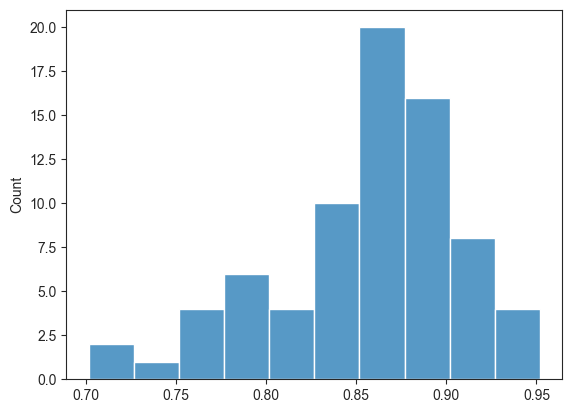

In [10]:
# plot scores
sns.histplot(scores)

In [11]:
# create Anndata with weights as X, and perturbation name and observation as obs variables
embeddings_adata = anndata.AnnData(X = np.array(list(embeddings.values())).squeeze())
embeddings_adata.obs_names = list(embeddings.keys())

# create dataframe with perturbation name and moa
pert_and_moa = adata.obs[['perturbation_name', 'gene_programme']].drop_duplicates()

# map perturbation name to moa
embeddings_adata.obs['gene_programme'] = embeddings_adata.obs_names.map(pert_and_moa.set_index('perturbation_name')['gene_programme'])

In [12]:
embeddings_adata

AnnData object with n_obs × n_vars = 75 × 30
    obs: 'gene_programme'

/opt/homebrew/Caskroom/mambaforge/base/envs/pertpy1/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/opt/homebrew/Caskroom/mambaforge/base/envs/pertpy1/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/homebrew/Caskroom/mambaforge/base/envs/pertpy1/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


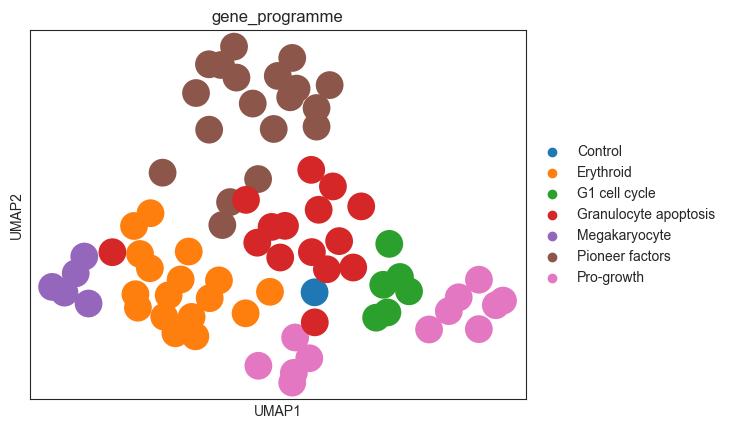

In [13]:
sc.pp.neighbors(embeddings_adata, use_rep='X')
sc.tl.umap(embeddings_adata)
sc.pl.umap(embeddings_adata, color=['gene_programme'])

/opt/homebrew/Caskroom/mambaforge/base/envs/pertpy1/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/opt/homebrew/Caskroom/mambaforge/base/envs/pertpy1/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/homebrew/Caskroom/mambaforge/base/envs/pertpy1/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


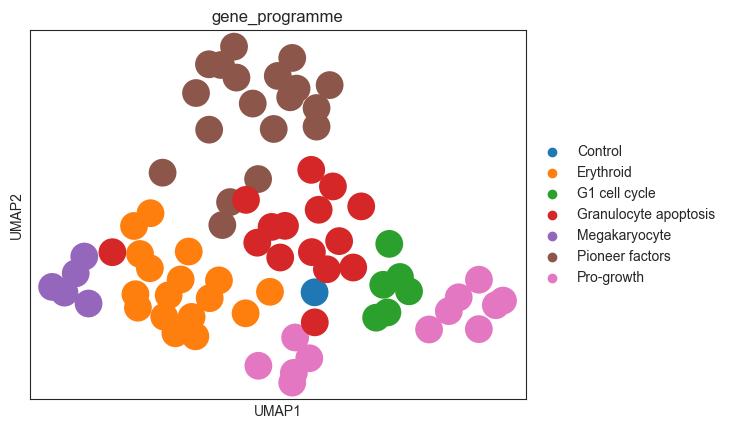

In [14]:
sc.pp.neighbors(embeddings_adata, use_rep='X')
sc.tl.umap(embeddings_adata)
sc.pl.umap(embeddings_adata, color=['gene_programme'])